<a href="https://colab.research.google.com/github/abramed/RREA/blob/master/CIKM/RREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/abramed/RREA.git

fatal: destination path 'RREA' already exists and is not an empty directory.


In [2]:
%cd /content/RREA/CIKM

/content/RREA/CIKM


In [3]:

import tensorflow.compat.v1 as tf

config = tf.ConfigProto()

config.gpu_options.allow_growth=True  
sess = tf.Session(config=config)  

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import keras
from tqdm import *
import numpy as np
from utils import *
from CSLS import *
import keras.backend as K
from keras.layers import *
from layer import NR_GraphAttention

''' os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) '''

#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True  
#sess = tf.Session(config=config)  

' os.environ["CUDA_VISIBLE_DEVICES"] = "0"\nos.environ["TF_CPP_MIN_LOG_LEVEL"]="2"\ntf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) '

In [5]:
lang = 'zh'
train_pair,dev_pair,adj_matrix,r_index,r_val,adj_features,rel_features = load_data('data/%s_en/'%lang,train_ratio=0.30)
adj_matrix = np.stack(adj_matrix.nonzero(),axis = 1)
rel_matrix,rel_val = np.stack(rel_features.nonzero(),axis = 1),rel_features.data
ent_matrix,ent_val = np.stack(adj_features.nonzero(),axis = 1),adj_features.data

38960 3025


In [6]:
node_size = adj_features.shape[0]
rel_size = rel_features.shape[1]
triple_size = len(adj_matrix)
batch_size = node_size


class TokenEmbedding(keras.layers.Embedding):
    """Embedding layer with weights returned."""

    def compute_output_shape(self, input_shape):
        return self.input_dim, self.output_dim

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs):
        return self.embeddings
    
def get_embedding():
    inputs = [adj_matrix,r_index,r_val,rel_matrix,ent_matrix]
    inputs = [np.expand_dims(item,axis=0) for item in inputs]
    return get_emb.predict_on_batch(inputs)

def test(wrank = None):
    vec = get_embedding()
    return  get_hits(vec,dev_pair,wrank=wrank)

def CSLS_test(thread_number = 16, csls=10,accurate = True):
    vec = get_embedding()
    Lvec = np.array([vec[e1] for e1, e2 in dev_pair])
    Rvec = np.array([vec[e2] for e1, e2 in dev_pair])
    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
    eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], thread_number, csls=csls, accurate=accurate)
    return None

def get_train_set(batch_size = batch_size):
    negative_ratio =  batch_size // len(train_pair) + 1
    train_set = np.reshape(np.repeat(np.expand_dims(train_pair,axis=0),axis=0,repeats=negative_ratio),newshape=(-1,2))
    np.random.shuffle(train_set); train_set = train_set[:batch_size]
    train_set = np.concatenate([train_set,np.random.randint(0,node_size,train_set.shape)],axis = -1)
    return train_set

def get_trgat(node_size,rel_size,node_hidden,rel_hidden,triple_size,n_attn_heads = 2,dropout_rate = 0,gamma = 3,lr = 0.005,depth = 2):
    adj_input = Input(shape=(None,2))
    index_input = Input(shape=(None,2),dtype='int64')
    val_input = Input(shape = (None,))
    rel_adj = Input(shape=(None,2))
    ent_adj = Input(shape=(None,2))
    
    ent_emb = TokenEmbedding(node_size,node_hidden,trainable = True)(val_input) 
    rel_emb = TokenEmbedding(rel_size,node_hidden,trainable = True)(val_input)
    
    def avg(tensor,size):
        adj = K.cast(K.squeeze(tensor[0],axis = 0),dtype = "int64")   
        adj = tf.SparseTensor(indices=adj, values=tf.ones_like(adj[:,0],dtype = 'float32'), dense_shape=(node_size,size)) 
        adj = tf.compat.v1.sparse_softmax(adj) 
        return tf.compat.v1.sparse_tensor_dense_matmul(adj,tensor[1])
    
    opt = [rel_emb,adj_input,index_input,val_input]
    ent_feature = Lambda(avg,arguments={'size':node_size})([ent_adj,ent_emb])
    rel_feature = Lambda(avg,arguments={'size':rel_size})([rel_adj,rel_emb])
    
    encoder = NR_GraphAttention(node_size,activation="relu",
                                       rel_size = rel_size,
                                       depth = depth,
                                       attn_heads=n_attn_heads,
                                       triple_size = triple_size,
                                       attn_heads_reduction='average',   
                                       dropout_rate=dropout_rate)
    
    out_feature = Concatenate(-1)([encoder([ent_feature]+opt),encoder([rel_feature]+opt)])
    out_feature = Dropout(dropout_rate)(out_feature)
    
    alignment_input = Input(shape=(None,4))
    find = Lambda(lambda x:K.gather(reference=x[0],indices=K.cast(K.squeeze(x[1],axis=0), 'int32')))([out_feature,alignment_input])
    
    def align_loss(tensor):
        def _cosine(x):
            dot1 = K.batch_dot(x[0], x[1], axes=1)
            dot2 = K.batch_dot(x[0], x[0], axes=1)
            dot3 = K.batch_dot(x[1], x[1], axes=1)
            max_ = K.maximum(K.sqrt(dot2 * dot3), K.epsilon())
            return dot1 / max_
        
        def l1(ll,rr):
            return K.sum(K.abs(ll-rr),axis=-1,keepdims=True)
        
        def l2(ll,rr):
            return K.sum(K.square(ll-rr),axis=-1,keepdims=True)
        
        l,r,fl,fr = [tensor[:,0,:],tensor[:,1,:],tensor[:,2 ,:],tensor[:,3,:]]
        loss = K.relu(gamma + l1(l,r) - l1(l,fr)) + K.relu(gamma + l1(l,r) - l1(fl,r))
        return tf.reduce_sum(loss,keepdims=True) / (batch_size)
    
    loss = Lambda(align_loss)(find)
    
    inputs = [adj_input,index_input,val_input,rel_adj,ent_adj]
    train_model = keras.Model(inputs = inputs + [alignment_input],outputs = loss)
    train_model.compile(loss=lambda y_true,y_pred: y_pred,optimizer=keras.optimizers.RMSprop(lr))
    
    feature_model = keras.Model(inputs = inputs,outputs = out_feature)
    return train_model,feature_model

In [7]:
model,get_emb = get_trgat(dropout_rate=0.30,node_size=node_size,rel_size=rel_size,n_attn_heads = 1,depth=2,gamma =3,node_hidden=100,rel_hidden = 100,triple_size = triple_size)
model.summary(); initial_weights = model.get_weights()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 token_embedding (TokenEmbeddin  (38960, 100)        3896000     ['input_3[0][0]']                
 g)                                                                                               
                                                                                                  
 token_embedding_1 (TokenEmbedd  (6050, 100)         605000      ['input_3[0][0]']            

In [8]:
rest_set_1 = [e1 for e1, e2 in dev_pair]
rest_set_2 = [e2 for e1, e2 in dev_pair]
np.random.shuffle(rest_set_1)
np.random.shuffle(rest_set_2)

epoch = 1200
for turn in range(5):
    print("iteration %d start."%turn)
    for i in trange(epoch):
        train_set = get_train_set()
        inputs = [adj_matrix,r_index,r_val,rel_matrix,ent_matrix,train_set]
        inputs = [np.expand_dims(item,axis=0) for item in inputs]
        model.train_on_batch(inputs,np.zeros((1,1)))
        if i%300 == 299:
            CSLS_test()

    new_pair = []
    vec = get_embedding()
    Lvec = np.array([vec[e] for e in rest_set_1])
    Rvec = np.array([vec[e] for e in rest_set_2])
    Lvec = Lvec / np.linalg.norm(Lvec,axis=-1,keepdims=True)
    Rvec = Rvec / np.linalg.norm(Rvec,axis=-1,keepdims=True)
    A,_ = eval_alignment_by_sim_mat(Lvec, Rvec, [1, 5, 10], 16,10,True,False)
    B,_ = eval_alignment_by_sim_mat(Rvec, Lvec,[1, 5, 10], 16,10,True,False)
    A = sorted(list(A)); B = sorted(list(B))
    for a,b in A:
        if  B[b][1] == a:
            new_pair.append([rest_set_1[a],rest_set_2[b]])
    print("generate new semi-pairs: %d." % len(new_pair))
    
    train_pair = np.concatenate([train_pair,np.array(new_pair)],axis = 0)
    for e1,e2 in new_pair:
        if e1 in rest_set_1:
            rest_set_1.remove(e1) 
        
    for e1,e2 in new_pair:
        if e2 in rest_set_2:
            rest_set_2.remove(e2) 
    

iteration 0 start.


  0%|          | 0/1200 [00:00<?, ?it/s]WARNING:tensorflow:
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'token_embedding_1/embeddings:0' shape=(6050, 100) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'token_embedding/embeddings:0' shape=(38960, 100) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.c

accurate results: hits@[1, 5, 10] = [69.48 88.91 93.06], mr = 11.589, mrr = 0.781, time = 17.862 s 


 50%|█████     | 600/1200 [06:16<1:03:25,  6.34s/it]

accurate results: hits@[1, 5, 10] = [70.49 89.58 93.46], mr = 12.861, mrr = 0.788, time = 18.924 s 


 75%|███████▌  | 900/1200 [09:22<32:08,  6.43s/it]

accurate results: hits@[1, 5, 10] = [71.1  89.55 93.35], mr = 14.120, mrr = 0.793, time = 19.136 s 


100%|██████████| 1200/1200 [12:28<00:00,  1.60it/s]

accurate results: hits@[1, 5, 10] = [71.18 89.56 93.41], mr = 15.143, mrr = 0.793, time = 16.530 s 


generate new semi-pairs: 7397.
iteration 1 start.


 25%|██▌       | 300/1200 [03:07<1:26:54,  5.79s/it]

accurate results: hits@[1, 5, 10] = [74.55 91.25 94.52], mr = 11.723, mrr = 0.819, time = 17.008 s 


 50%|█████     | 600/1200 [06:15<1:04:00,  6.40s/it]

accurate results: hits@[1, 5, 10] = [75.04 91.58 94.55], mr = 11.854, mrr = 0.823, time = 19.111 s 


 75%|███████▌  | 900/1200 [09:22<30:05,  6.02s/it]

accurate results: hits@[1, 5, 10] = [75.28 91.33 94.5 ], mr = 12.008, mrr = 0.824, time = 17.483 s 


100%|██████████| 1200/1200 [12:27<00:00,  1.60it/s]

accurate results: hits@[1, 5, 10] = [75.67 91.65 94.46], mr = 12.341, mrr = 0.827, time = 17.140 s 


generate new semi-pairs: 1751.
iteration 2 start.


 25%|██▌       | 300/1200 [03:01<1:26:16,  5.75s/it]

accurate results: hits@[1, 5, 10] = [77.86 91.83 94.88], mr = 11.875, mrr = 0.841, time = 16.538 s 


 50%|█████     | 600/1200 [06:02<1:01:57,  6.20s/it]

accurate results: hits@[1, 5, 10] = [78.14 91.78 94.81], mr = 12.609, mrr = 0.843, time = 17.742 s 


 75%|███████▌  | 900/1200 [08:59<28:49,  5.76s/it]

accurate results: hits@[1, 5, 10] = [78.61 91.91 94.85], mr = 11.762, mrr = 0.845, time = 17.044 s 


100%|██████████| 1200/1200 [11:57<00:00,  1.67it/s]

accurate results: hits@[1, 5, 10] = [78.68 91.89 94.73], mr = 12.229, mrr = 0.846, time = 17.272 s 


generate new semi-pairs: 644.
iteration 3 start.


 25%|██▌       | 300/1200 [02:56<1:21:27,  5.43s/it]

accurate results: hits@[1, 5, 10] = [79.38 92.11 94.82], mr = 12.469, mrr = 0.852, time = 15.839 s 


 50%|████▉     | 599/1200 [05:34<04:56,  2.03it/s]

accurate results: hits@[1, 5, 10] = [79.6  92.46 94.96], mr = 13.009, mrr = 0.853, time = 16.755 s 


 75%|███████▌  | 900/1200 [08:59<29:59,  6.00s/it]

accurate results: hits@[1, 5, 10] = [79.39 92.4  94.9 ], mr = 15.041, mrr = 0.852, time = 17.307 s 


100%|██████████| 1200/1200 [11:59<00:00,  1.67it/s]

accurate results: hits@[1, 5, 10] = [79.71 92.27 94.79], mr = 13.738, mrr = 0.853, time = 18.002 s 


generate new semi-pairs: 295.
iteration 4 start.


 25%|██▌       | 300/1200 [03:02<1:23:52,  5.59s/it]

accurate results: hits@[1, 5, 10] = [80.07 92.57 94.87], mr = 14.652, mrr = 0.856, time = 16.089 s 


 50%|█████     | 600/1200 [06:03<1:00:18,  6.03s/it]

accurate results: hits@[1, 5, 10] = [80.43 92.5  94.88], mr = 15.145, mrr = 0.858, time = 17.242 s 


 75%|███████▌  | 900/1200 [09:02<30:34,  6.12s/it]

accurate results: hits@[1, 5, 10] = [80.27 92.44 94.88], mr = 15.324, mrr = 0.857, time = 17.870 s 


100%|█████████▉| 1199/1200 [11:46<00:00,  1.99it/s]

accurate results: hits@[1, 5, 10] = [80.17 92.37 94.63], mr = 15.243, mrr = 0.857, time = 16.760 s 


100%|██████████| 1200/1200 [12:04<00:00,  1.66it/s]


generate new semi-pairs: 171.


In [8]:
model.save_weights('model_weights.tf')

In [9]:
model.save_weights('model_weights.tf')

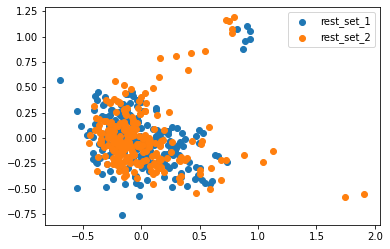

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get embeddings
vec = get_embedding()
Lvec = np.array([vec[e] for e in rest_set_1])
Rvec = np.array([vec[e] for e in rest_set_2])

# apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
Lvec_pca = pca.fit_transform(Lvec)
Rvec_pca = pca.fit_transform(Rvec)

# plot embeddings
fig, ax = plt.subplots()
ax.scatter(Lvec_pca[:, 0], Lvec_pca[:, 1], label='rest_set_1')
ax.scatter(Rvec_pca[:, 0], Rvec_pca[:, 1], label='rest_set_2')
ax.legend()
plt.show()

AttributeError: ignored

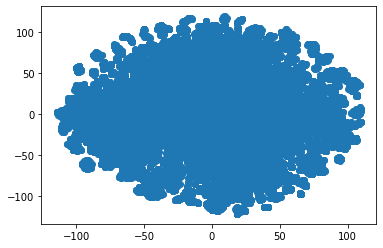

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# get embeddings
vec = get_embedding()

# apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2)
vec_tsne = tsne.fit_transform(vec)

# plot embeddings
fig, ax = plt.subplots()
ax.scatter(vec_tsne[:, 0], vec_tsne[:, 1])

plt.show()
